# **Classification of Shapes**

## **Importing modules**

In [1]:
import os
import pathlib
import cv2
import glob
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.utils import to_categorical
#from tf_keras_vis.saliency import Saliency
#from tf_keras_vis.utils import normalize
#from tf_keras_vis.gradcam import Gradcam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input


import random

from shape_load_image import create_data_sets


In [2]:
# Run this cell for more readable visuals 
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.style.use('seaborn-whitegrid')
plt.rcParams.update(params)
%matplotlib inline

## **Loading the data and Preprocessing**

In [3]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ncopy=0

x,y,size_x,size_y=create_data_sets(ncopy)

Number of directories : 65 

Data read from  /content/drive/MyDrive/synthetic_shape_data_all/sph_D050/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Creating first dataset

Data read from  /content/drive/MyDrive/synthetic_shape_data_all/sph_D038/*.png
      Total number of images read = 100
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/synthetic_shape_data_all/sph_D047/*.png
      Total number of images read = 97
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/synthetic_shape_data_all/sph_D030/*.png
      Total number of images read = 58
      Pixels in each image = 142  *  142
      Total number of pixels 20164
         Appending datasets

Data read from  /content/drive/MyDrive/synthetic_shape_data_all/sph_D035/

Text(0.5, 0.98, 'Sample of train images')

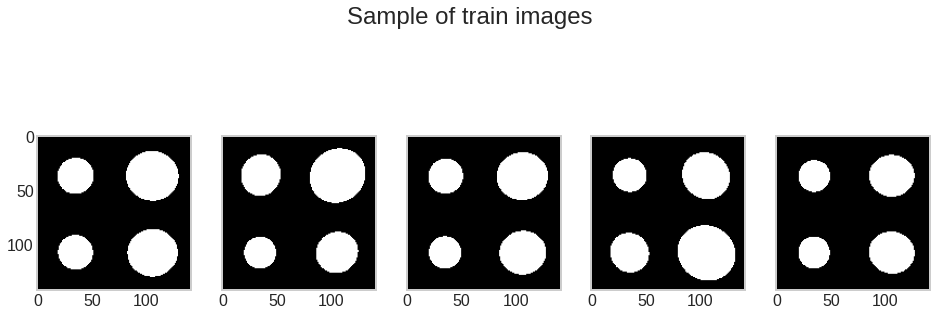

In [5]:
fig, ax = plt.subplots(1,5,figsize = (16,6), sharey=True)
for i in range(0,5):
  ax[i].imshow(x[i,:,:,0],cmap="gray")
  ax[i].grid(None)
fig.suptitle("Sample of train images", fontsize=24)

## **Splitting into train, validation and test datasets**

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train=x_train/255.0
x_test =x_test/255.0
print(x_train.shape, x_test.shape)


(5164, 142, 142, 1) (1291, 142, 142, 1)


Text(0.5, 0.98, 'Random sample of train images')

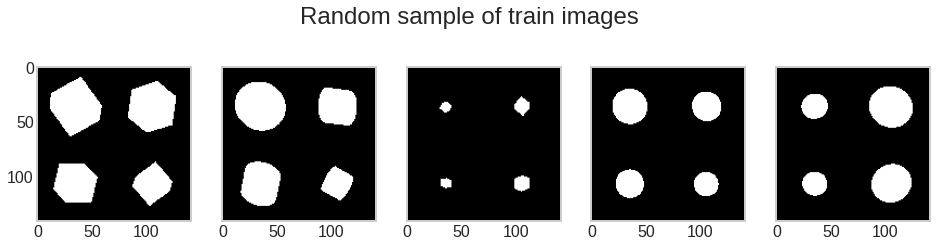

In [7]:
fig, ax = plt.subplots(1,5,figsize = (16,4), sharey=True)
for i in range(0,5):
  ax[i].imshow(x_train[-1-i,:,:,0],cmap="gray")
  ax[i].grid(None)
fig.suptitle("Random sample of train images", fontsize=24)

## **Creating a model**

In [8]:
def define_model(filter):
  #defining the model based on filters
  model = Sequential()
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003), input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.2))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.2))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(Conv2D(filter, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.003)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(filter, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.003)))
  model.add(Dense(3, activation='softmax'))
	# compile model
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model
 

In [9]:
tf.keras.backend.clear_session()
model = define_model(64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 142, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                    

## **Evaluating the results with test data**

In [10]:
# fit model
model_history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test), verbose=1)


Epoch 1/15
81/81 [==============================] - 42s 338ms/step - loss: 3.1780 - accuracy: 0.5492 - val_loss: 2.3146 - val_accuracy: 0.7072
Epoch 2/15
81/81 [==============================] - 24s 292ms/step - loss: 1.8919 - accuracy: 0.8286 - val_loss: 1.5705 - val_accuracy: 0.9040
Epoch 3/15
81/81 [==============================] - 24s 292ms/step - loss: 1.4126 - accuracy: 0.9070 - val_loss: 1.3180 - val_accuracy: 0.8908
Epoch 4/15
81/81 [==============================] - 24s 292ms/step - loss: 1.1551 - accuracy: 0.9241 - val_loss: 1.1001 - val_accuracy: 0.9249
Epoch 5/15
81/81 [==============================] - 24s 292ms/step - loss: 0.9693 - accuracy: 0.9390 - val_loss: 0.9084 - val_accuracy: 0.9411
Epoch 6/15
81/81 [==============================] - 24s 293ms/step - loss: 0.8413 - accuracy: 0.9425 - val_loss: 0.7966 - val_accuracy: 0.9349
Epoch 7/15
81/81 [==============================] - 24s 303ms/step - loss: 0.7317 - accuracy: 0.9477 - val_loss: 0.7070 - val_accuracy: 0.9365

In [11]:
# evaluate model
_, acc = model.evaluate(x_test, y_test, verbose=1)
print('> %.3f' % (acc * 100.0))

41/41 [==============================] - 3s 51ms/step - loss: 0.3844 - accuracy: 0.9450
> 94.500


Text(0.5, 0.98, 'Model Training and Test Loss and Accuracy')

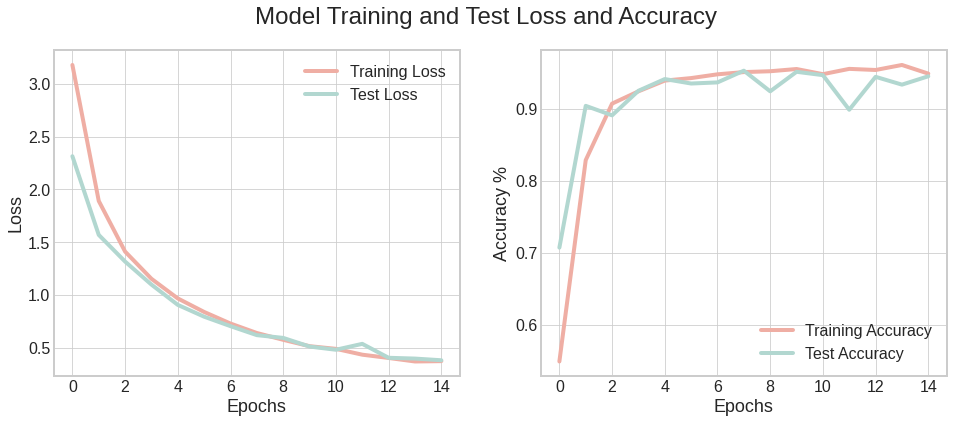

In [12]:
# learning curves
# plot train and val acc as  a function of epochs
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(model_history.history['loss'],color='#EFAEA4',label = 'Training Loss',linewidth=4.0)
ax[0].plot(model_history.history['val_loss'],color='#B2D7D0',label = 'Test Loss',linewidth=4.0)
ax[1].plot(model_history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy',linewidth=4.0)
ax[1].plot(model_history.history['val_accuracy'],color='#B2D7D0',label = 'Test Accuracy',linewidth=4.0)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs', fontsize=18)
ax[1].set_xlabel('Epochs', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=18)
ax[1].set_ylabel('Accuracy %', fontsize=18);
fig.suptitle('Model Training and Test Loss and Accuracy', fontsize = 24)

In [13]:
from prettytable import PrettyTable
# your code here
print('CNN Regularized Model Summary')
model_table= PrettyTable()

model_table.field_names = ["Parameter", "Train", "Validation", "Difference (Train-Val)"]
model_table.add_row(["Loss", round(model_history.history['loss'][-10],2), round(model_history.history['val_loss'][-10],6), round(model_history.history['loss'][-10]-model_history.history['val_loss'][-10],6)])
model_table.add_row(["Accuracy", round(model_history.history['accuracy'][-10],6), round(model_history.history['val_accuracy'][-10],6), round(model_history.history['accuracy'][-10]-model_history.history['val_accuracy'][-10],6)])
print(model_table)

CNN Regularized Model Summary
+-----------+----------+------------+------------------------+
| Parameter |  Train   | Validation | Difference (Train-Val) |
+-----------+----------+------------+------------------------+
|    Loss   |   0.84   |  0.796591  |        0.044741        |
|  Accuracy | 0.942486 |  0.934934  |        0.007552        |
+-----------+----------+------------+------------------------+


## **Error Analysis**

In [14]:
print("\nPrediction Error on Test Set")
y_pred_test = model.predict(x_test)
image_dict = {0:'Cylinder', 1:"Cuboid", 2:"Sphere"}



Prediction Error on Test Set


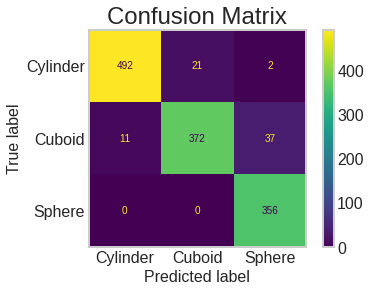

<Figure size 432x288 with 0 Axes>

In [15]:

cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_test, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['Cylinder', 'Cuboid', 'Sphere'])
disp.plot()
plt.grid(None)
plt.title("Confusion Matrix", fontsize=24)
plt.show()
plt.savefig('ConfusionMatrix.pdf')

In [16]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_test, axis=1), target_names=['Cylinder', 'Cuboid', 'Sphere']))

              precision    recall  f1-score   support

    Cylinder       0.98      0.96      0.97       515
      Cuboid       0.95      0.89      0.92       420
      Sphere       0.90      1.00      0.95       356

    accuracy                           0.95      1291
   macro avg       0.94      0.95      0.94      1291
weighted avg       0.95      0.95      0.94      1291



In [17]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

(142, 142, 1)


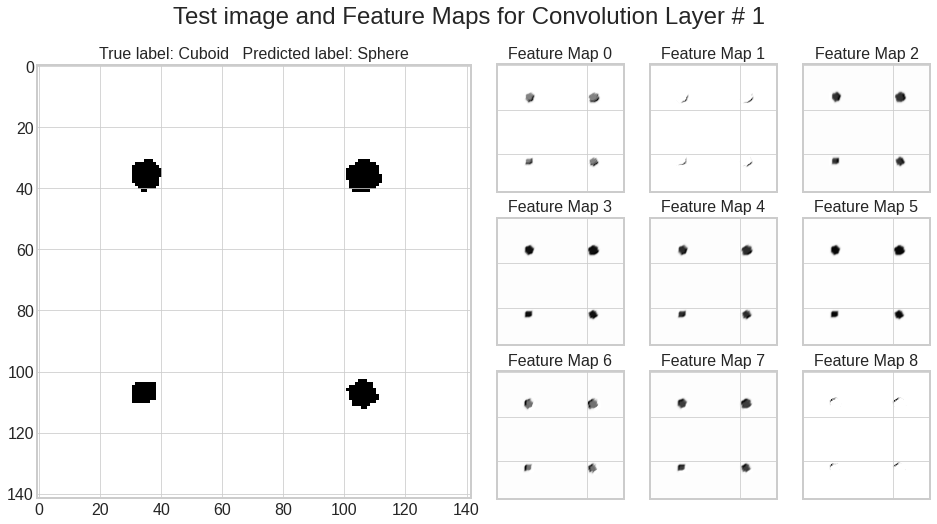

In [27]:
# your code here

image_label = 1
layer_number=1

istar =-1
for i in range(x_test.shape[0]):
  if (np.argmax(y_pred_test[i])!= np.argmax(y_test[i]) == image_label):
    istar=i
    break

if (istar==-1):
  print("Test Image Not Found")
else:
  input_image = x_test[istar]
  print(input_image.shape)
  feature_maps = get_feature_maps(model, layer_number, input_image)

  fig = plt.figure(figsize=(16,8))

  true_class = image_dict[np.argmax(y_test[istar])]
  pred_class = image_dict[np.argmax(y_pred_test[istar])]
  ax0 = plt.subplot2grid((3,6), (0,0), colspan=3, rowspan=3)
  ax0.imshow(np.squeeze(input_image))
  ax0.set_title('True label: '+ true_class + '   Predicted label: ' + pred_class)

  count=0
  for i in range(3):
    for j in range(3):
      
      plot1 = plt.subplot2grid((3,6), (i,j+3), colspan=1, rowspan=1)
      plot1.imshow(feature_maps[count])
      plot1.set_yticklabels([])
      plot1.set_xticklabels([])
      plot1.set_title("Feature Map "+str(count))
      count +=1

  fig.suptitle(f'Test image and Feature Maps for Convolution Layer # {layer_number}', fontsize=24)